# User's metadata Analysis

This notebook helps to retrieve, analyse and visualize user's metadata for all the users from the **large** database (>19'000 unique users).

In particular, this notebook contains :
* reusable functions for any users in Wikipedia
* plots visualization to see patterns
* analysis of the results to understand the impact of the metadata of a user and his editing behaviour.

We retrieved metadata through Wikipedia's API using the ```action=query``` endpoint with ```list=users``` and the parameters ```ucprop=blockinfo|groups|editcount|registration|emailable|gender```.

The final goal of this notebook is find some features that reveals certain weaponizing patterns that can retrieved and keep for the developpement of an LLM.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
import calendar
from datetime import timedelta
from scipy.stats import variation
from tqdm import tqdm

In [2]:
# import our small preprocessed database
df = pd.read_csv('../../datas/final/large_db_preprocess.csv')

In [3]:

# Users list
top10_users = df["user"].value_counts().head(10).index.tolist()
users_list = df['user'].unique().tolist()
df_ip = df[df['user_type'] == 'Anonymous (IP)']
top10_ip_users = df_ip["user"].value_counts().head(10).index.tolist()

# load users metadata retrieved using wikipedia API
df_all_user_metadata = pd.read_csv('../../datas/interim/Full Database/users_metadata_df.csv')

In [4]:
# after cleaning, we merge the metadata dataframe to the database

df_all_user_metadata=df_all_user_metadata.dropna(axis='index', how='any', subset=['registration'])
df_all_user_metadata = df_all_user_metadata.rename(columns={"name": "user"})
df_enriched = df.merge(
    df_all_user_metadata,
    on="user",
    how="left"
)

In [5]:
df_enriched.head(5)

,initial_version,changed_version,comment,user,date,llm_output,weaponised,article,user_type,editcount,...,blockexpiry,blocknocreate,blockedtimestampformatted,blockowntalk,blockemail,missing,blockexpiryformatted,blockexpiryrelative,blockpartial,invalid
0,{{main|2020 coronavirus outbreak in Europe}}\n...,Initial revision,create page,Dying,2020-03-03T23:46:58Z,Added initial revision content.\n\nNot Weaponi...,Not Weaponised,COVID-19 pandemic in Ukraine,Registered,11773.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,{{main|2020 coronavirus outbreak in Europe}}\n...,"--- \n+++ \n@@ -10,7 +10,7 @@\n | virus_strain...",changed arrival_date 2020.03.03 in [[Template:...,Neo-Jay,2020-03-04T00:05:02Z,"Changed the format of the arrival date from ""2...",Not Weaponised,COVID-19 pandemic in Ukraine,Registered,53888.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,{{main|2020 coronavirus outbreak in Europe}}\n...,"--- \n+++ \n@@ -17,7 +17,7 @@\n \n == Timeline...",NaN,Unlogged by Anti-1337 People,2020-03-11T10:54:13Z,"Changed the date from ""27 January 2020"" to ""27...",Not Weaponised,COVID-19 pandemic in Ukraine,Registered,35.0,...,infinite,NaN,"11:21, 11 March 2020",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,{{main|2020 coronavirus outbreak in Europe}}\n...,"--- \n+++ \n@@ -17,7 +17,7 @@\n | recovery_cas...",NaN,1857a,2020-03-04T00:54:47Z,"Changed the date format from ""2020.03.03"" to ""...",Not Weaponised,COVID-19 pandemic in Ukraine,Registered,10623.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,{{main|2020 coronavirus outbreak in Europe}}\n...,"--- \n+++ \n@@ -1,5 +1,3 @@\n-{{see also|2019–...",/* top */ [[WP:HATNOTES|hatnotes]] are used if...,Uanfala,2020-03-05T19:12:54Z,Removed two hatnote templates related to the 2...,Not Weaponised,COVID-19 pandemic in Ukraine,Registered,65714.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Gender

In [6]:
df_all_user_metadata['gender'].value_counts()

gender
unknown    6658
male       2147
female      222
Name: count, dtype: int64

<Axes: title={'center': 'Weaponised vs Non-Weaponised Edits by Gender'}, xlabel='gender', ylabel='Percentage of Edits (%)'>

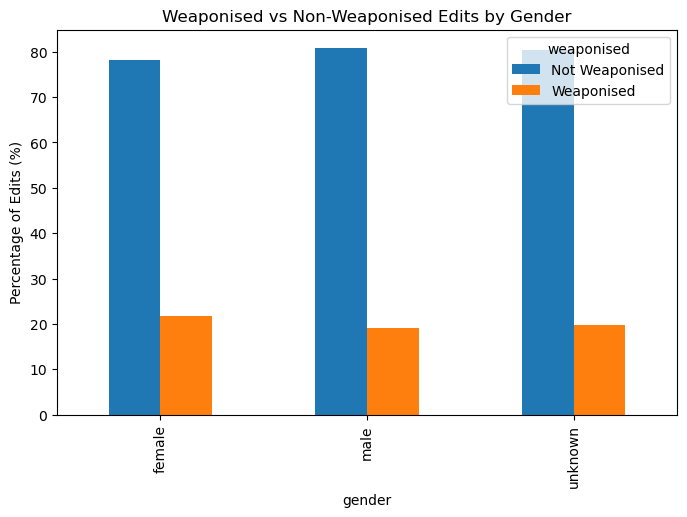

In [7]:
pd.crosstab(
    df_enriched['gender'],
    df_enriched['weaponised'],
    normalize='index'
).mul(100).plot.bar(
    figsize=(8,5),
    title="Weaponised vs Non-Weaponised Edits by Gender",
    ylabel="Percentage of Edits (%)"
)

## Block 

In [8]:
df_all_user_metadata_block = df_all_user_metadata.dropna(axis='index', how='any', subset=['blockid'])
df_all_user_metadata_block


,user,editcount,registration,groups,gender,emailable,blockid,blockedby,blockedbyid,blockreason,...,blockexpiry,blocknocreate,blockedtimestampformatted,blockowntalk,blockemail,missing,blockexpiryformatted,blockexpiryrelative,blockpartial,invalid
2,Unlogged by Anti-1337 People,35.0,2020-03-11T10:39:30Z,"['*', 'user', 'autoconfirmed']",unknown,NaN,9661252.0,Bishonen,85193.0,[[WP:Vandalism-only account|Vandalism-only acc...,...,infinite,NaN,"11:21, 11 March 2020",NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,CLCStudent,315516.0,2015-09-30T19:37:10Z,"['extendedconfirmed', 'reviewer', '*', 'user',...",male,NaN,10405207.0,TonyBallioni,5527268.0,{{checkuserblock-account}},...,infinite,NaN,"21:59, 23 February 2021",NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,Adûnâi,4023.0,2014-07-17T20:52:01Z,"['extendedconfirmed', '*', 'user', 'autoconfir...",unknown,NaN,9991115.0,Ohnoitsjamie,507787.0,[[WP:No personal attacks|Personal attacks]] or...,...,infinite,NaN,"14:05, 3 August 2020",NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,Tvorozhok,8.0,2020-03-20T03:40:34Z,"['*', 'user']",unknown,NaN,9678808.0,Ymblanter,14596827.0,[[WP:Vandalism-only account|Vandalism-only acc...,...,infinite,NaN,"06:37, 20 March 2020",NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,DePiep,294285.0,2005-02-26T14:48:50Z,"['extendedconfirmed', '*', 'user', 'autoconfir...",unknown,NaN,19499496.0,Tamzin,17820167.0,[[WP:CBAN|Sitebanned by the community]] per [[...,...,infinite,NaN,"11:42, 28 April 2023",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9031,Priharisid,185.0,2024-07-12T22:58:29Z,"['*', 'user', 'autoconfirmed']",unknown,NaN,25075296.0,DrKay,2387872.0,Persistent addition of [[WP:INTREF|unsourced c...,...,infinite,NaN,"22:42, 23 December 2024",NaN,NaN,NaN,NaN,NaN,NaN,NaN
9035,Rochambeau1783,6134.0,2020-08-08T08:46:02Z,"['extendedconfirmed', '*', 'user', 'autoconfir...",unknown,NaN,25259627.0,Asilvering,42788136.0,{{checkuserblock-account}}: Abusing [[WP:SOCK|...,...,infinite,NaN,"04:40, 26 October 2025",NaN,NaN,NaN,NaN,NaN,NaN,NaN
9036,Bildete,3145.0,2024-11-06T16:03:09Z,"['extendedconfirmed', '*', 'user', 'autoconfir...",unknown,NaN,25273698.0,Blablubbs,22922645.0,Abusing [[WP:SOCK|multiple accounts]]: Please ...,...,infinite,NaN,"11:51, 15 November 2025",NaN,NaN,NaN,NaN,NaN,NaN,NaN
9052,Euromaidan,1.0,2013-11-26T09:20:51Z,"['*', 'user']",unknown,NaN,4839064.0,Yunshui,10345689.0,{{uw-softerblock}},...,infinite,NaN,"13:30, 27 November 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: ylabel='count'>

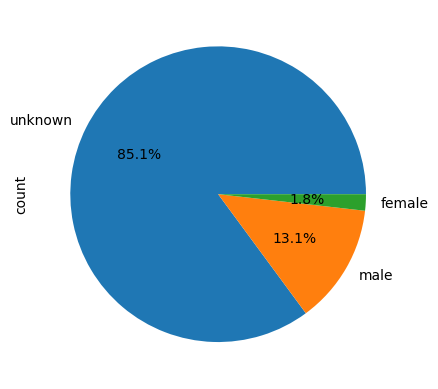

In [9]:
df_all_user_metadata_block['gender'].value_counts().plot.pie(autopct='%1.1f%%')

<Axes: ylabel='Frequency'>

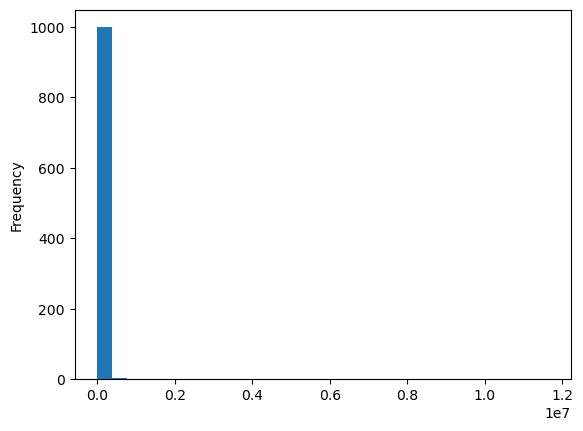

In [10]:
df_all_user_metadata_block['editcount'].plot.hist(bins=30)

In [11]:
# get a valid date format for the registration date
df_all_user_metadata_block['registration'] = pd.to_datetime(
    df_all_user_metadata_block['registration'],
    errors='coerce'
)

# get a valid date format for the block date
df_all_user_metadata_block['blockedtimestamp'] = pd.to_datetime(
    df_all_user_metadata_block['blockedtimestamp'],
    errors='coerce'
)

# compute the difference between the 2
df_all_user_metadata_block['days_to_block'] = (
    df_all_user_metadata_block['blockedtimestamp']
    - df_all_user_metadata_block['registration']
).dt.days

# ensure the values are valid
df_all_user_metadata_block = df_all_user_metadata_block[
    df_all_user_metadata_block['days_to_block'] >= 0
]

# 6.9 percent of users blocked within the 24 hours after their account creation date
(df_all_user_metadata_block['days_to_block'] <= 1).mean() * 100

/var/folders/t4/w6j9k5hs52b5jx9px2689lzc0000gn/T/ipykernel_61105/2805693770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_user_metadata_block['registration'] = pd.to_datetime(
/var/folders/t4/w6j9k5hs52b5jx9px2689lzc0000gn/T/ipykernel_61105/2805693770.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_user_metadata_block['blockedtimestamp'] = pd.to_datetime(
/var/folders/t4/w6j9k5hs52b5jx9px2689lzc0000gn/T/ipykernel_61105/2805693770.py:14: SettingWithCopyWarning: 
A value is trying to b

10.02979145978153

<Axes: ylabel='Frequency'>

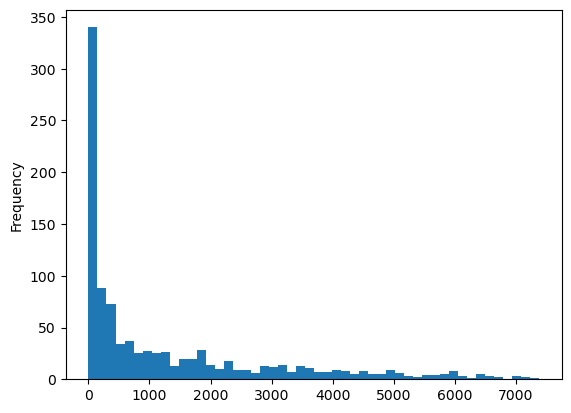

In [12]:
df_all_user_metadata_block['days_to_block'].plot.hist(bins=50)

<Axes: title={'center': 'Weaponised vs Non-Weaponised Edits by Block Status'}, xlabel='is_blocked', ylabel='Percentage of Edits (%)'>

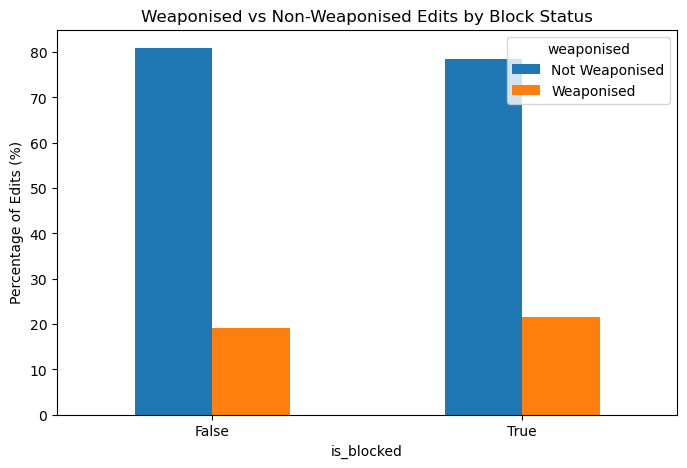

In [13]:
df_enriched['is_blocked'] = df_enriched['blockid'].notna()

pd.crosstab(
    df_enriched['is_blocked'],
    df_enriched['weaponised'],
    normalize='index'
).mul(100).plot.bar(
    figsize=(8,5),
    title="Weaponised vs Non-Weaponised Edits by Block Status",
    ylabel="Percentage of Edits (%)",
    rot=0
)

## Registration

/var/folders/t4/w6j9k5hs52b5jx9px2689lzc0000gn/T/ipykernel_61105/3547387567.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["user_type", "age_bin"])["weaponised_rate"]


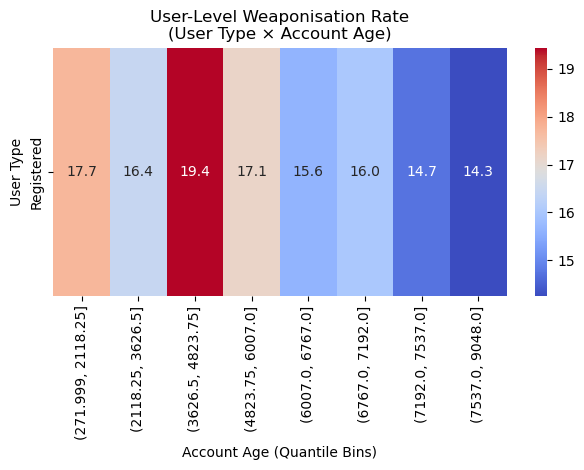

In [17]:
def compute_account_age(df_metadata, registration_col="registration", output_col="account_age_days"):
    """
    Compute the account age (in days) for each user given a metadata dataframe.

    Parameters
    ----------
    df_metadata : pd.DataFrame
        DataFrame containing user-level metadata, including their registration timestamp.
    
    registration_col : str, optional
        Name of the column containing registration timestamps (default: "registration").
    
    output_col : str, optional
        Name of the output column where account age will be stored (default: "account_age_days").

    Returns
    -------
    pd.DataFrame
        Same dataframe with an additional column representing the account age in days.
    
    Notes
    -----
    - If registration date is missing or invalid, age will be set to NaN.
    - Uses UTC timestamps (as provided by the Wikipedia API).
    """
    
    df = df_metadata.copy()

    # Convert registration date to datetime
    df[registration_col] = pd.to_datetime(df[registration_col], errors="coerce")

    # Compute age
    df[output_col] = (pd.Timestamp.utcnow() - df[registration_col]).dt.days

    return df

df_enriched_registration = compute_account_age(df_enriched)
df_enriched_registration = df_enriched_registration[df_enriched_registration['user_type'] == 'Registered']

df_enriched_registration["weaponised_binary"] = (
    df_enriched_registration["weaponised"]
    .eq("Weaponised")
    .astype(int)
)

user_level = (
    df_enriched_registration
    .groupby(["user", "user_type"])
    .agg(
        account_age_days=("account_age_days", "first"),
        weaponised_rate=("weaponised_binary", "mean")
    )
)

user_level["age_bin"] = pd.qcut(user_level["account_age_days"], q=8)

pivot_user = (
    user_level
    .groupby(["user_type", "age_bin"])["weaponised_rate"]
    .mean()
    .mul(100)
    .unstack()
)

sns.heatmap(pivot_user, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("User-Level Weaponisation Rate\n(User Type × Account Age)")
plt.ylabel("User Type")
plt.xlabel("Account Age (Quantile Bins)")
plt.tight_layout()
plt.show()


## Editcount

/var/folders/t4/w6j9k5hs52b5jx9px2689lzc0000gn/T/ipykernel_61105/548309439.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("editcount_bin")["weaponised_binary"]


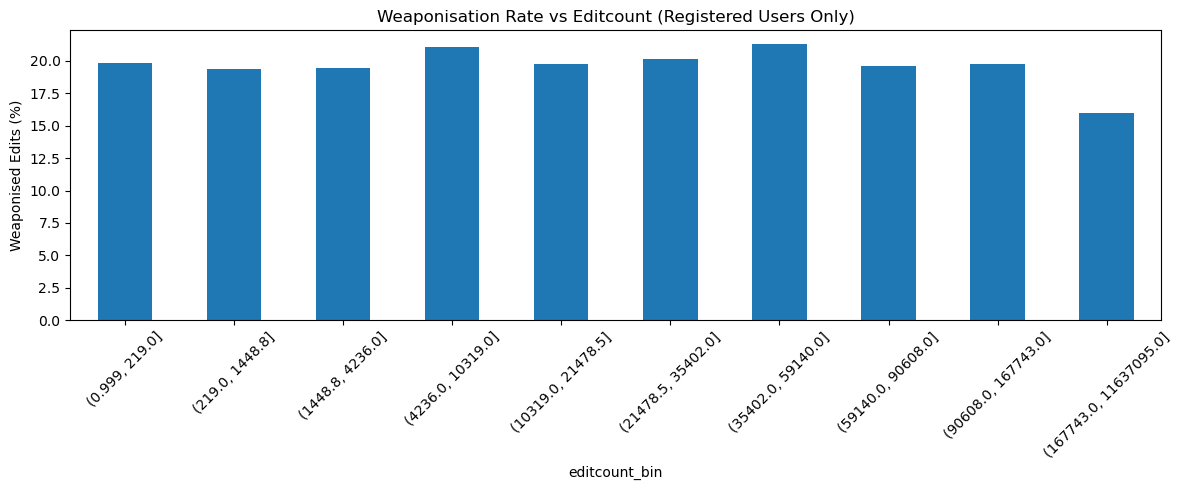

In [15]:
(
    df_enriched[df_enriched["user_type"] == "Registered"]
    .assign(
        weaponised_binary=lambda d: d["weaponised"].eq("Weaponised").astype(int),
        editcount_bin=lambda d: pd.qcut(d["editcount"], q=10, duplicates="drop")
    )
    .groupby("editcount_bin")["weaponised_binary"]
    .mean()
    .mul(100)
    .plot.bar(
        figsize=(12, 5),
        title="Weaponisation Rate vs Editcount (Registered Users Only)",
        ylabel="Weaponised Edits (%)",
        rot=45
    )
)
plt.tight_layout()
plt.show()


## Account age and editcount

/var/folders/t4/w6j9k5hs52b5jx9px2689lzc0000gn/T/ipykernel_61105/905664244.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["age_bin", "editcount_bin"])["weaponised_binary"]


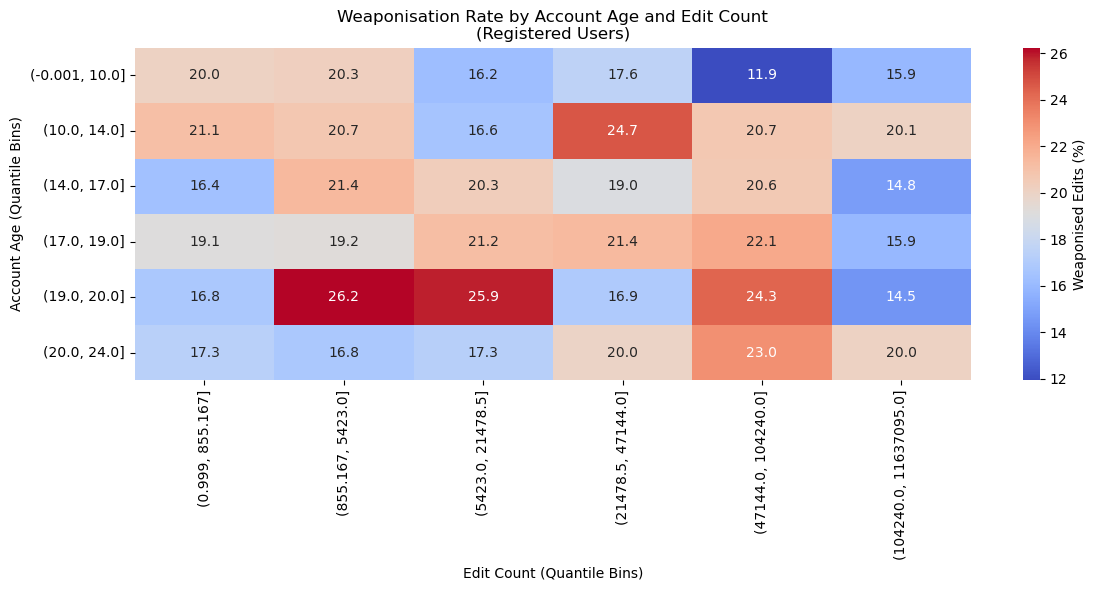

In [18]:
df_enriched_age = compute_account_age(df_enriched)

df_reg = df_enriched_age[df_enriched_age["user_type"] == "Registered"].copy()

df_reg["weaponised_binary"] = df_reg["weaponised"].eq("Weaponised").astype(int)

df_reg["account_age_years"] = df_reg["account_age_days"] // 365

df_reg["editcount_bin"] = pd.qcut(df_reg["editcount"], q=6, duplicates="drop")
df_reg["age_bin"] = pd.qcut(df_reg["account_age_years"], q=6, duplicates="drop")

pivot = (
    df_reg
    .groupby(["age_bin", "editcount_bin"])["weaponised_binary"]
    .mean()
    .mul(100)
    .unstack()
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot,
    cmap="coolwarm",
    annot=True,
    fmt=".1f",
    cbar_kws={"label": "Weaponised Edits (%)"}
)

plt.title("Weaponisation Rate by Account Age and Edit Count\n(Registered Users)")
plt.xlabel("Edit Count (Quantile Bins)")
plt.ylabel("Account Age (Quantile Bins)")
plt.tight_layout()
plt.show()


## Groups

In [19]:
import ast

def parse_groups(val):
    if pd.isna(val):
        return []
    try:
        # Ensure it's list-like
        return [g.strip() for g in ast.literal_eval(val)]
    except Exception:
        # Fallback if malformed
        return []

df_enriched["groups"] = df_enriched["groups"].apply(parse_groups)

all_groups = [
    g
    for groups in df_enriched["groups"]
    for g in groups
]

unique_groups = sorted(set(all_groups))

print(f"Number of unique rights: {len(unique_groups)}")
for g in unique_groups:
    print("-", g)

df_enriched["groups"] = df_enriched["groups"].apply(
    lambda g: [x for x in g if x != "*"]
)


Number of unique rights: 25
- *
- abusefilter
- abusefilter-helper
- accountcreator
- autoconfirmed
- autoreviewer
- bureaucrat
- checkuser
- electionclerk
- eventcoordinator
- extendedconfirmed
- extendedmover
- filemover
- import
- interface-admin
- ipblock-exempt
- massmessage-sender
- patroller
- reviewer
- rollbacker
- suppress
- sysop
- templateeditor
- temporary-account-viewer
- user


In [20]:
df_groups = df_enriched.explode("groups")
df_groups = df_groups[df_groups["groups"] != ""]

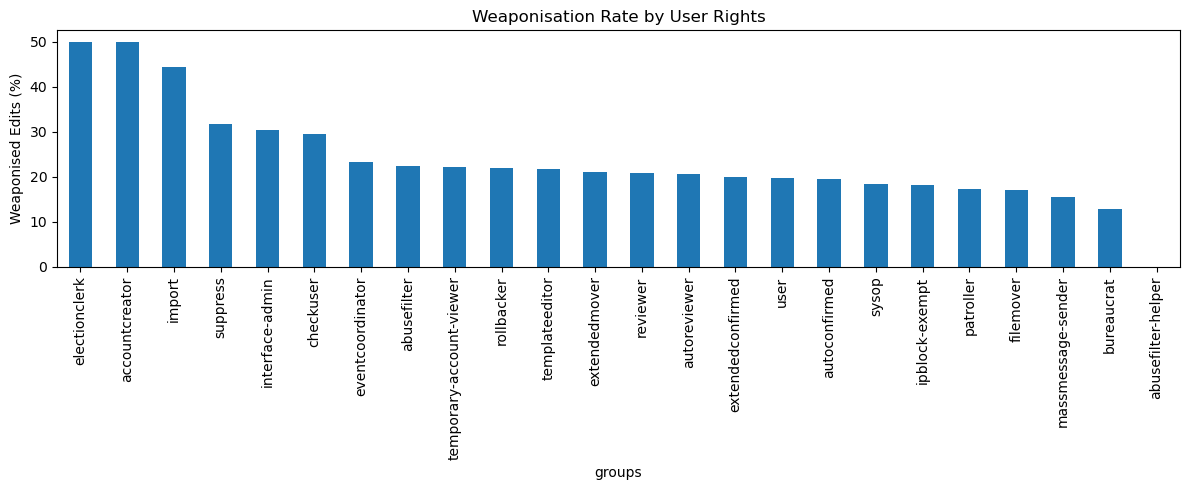

In [21]:
(
    df_groups
    .groupby("groups")["weaponised"]
    .apply(lambda s: (s == "Weaponised").mean() * 100)
    .sort_values(ascending=False)
    .plot.bar(figsize=(12,5))
)
plt.ylabel("Weaponised Edits (%)")
plt.title("Weaponisation Rate by User Rights")
plt.tight_layout()
plt.show()